In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
# !conda install -c rapidsai -c nvidia -c conda-forge -c defaults cuml=23.2 python=3.10 cudatoolkit=11.8 -y
# !pip install xgboost --upgrade
from xgboost import XGBRegressor

print('Data source import complete.')


Data source import complete.


Pakai kalau kamu punya label (target) yang jelas dan ingin memprediksi sesuatu.

Contoh target yang bisa dipakai dari dataset ini:

Memprediksi siapa yang menang (Winner)
→ fitur: rating putih/hitam, opening, jumlah langkah, dll
→ model: klasifikasi (White, Black, Draw)

Memprediksi apakah game rated atau tidak (Rated)
→ fitur: rating, status, opening, durasi
→ model: klasifikasi (binary)

Memprediksi jumlah langkah (Number of Turns)
→ model: regresi

📌 Model yang cocok:

Random Forest, XGBoost, Logistic Regression, SVM, dll.

In [2]:
import kagglehub
import numpy as np
import xgboost as xgb
import cupy as cp
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
# Download latest version

data_path = "/kaggle/input/chess/games.csv"
print(data_path)

/kaggle/input/chess/games.csv


In [3]:
df = pd.read_csv(data_path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [5]:
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


<Axes: >

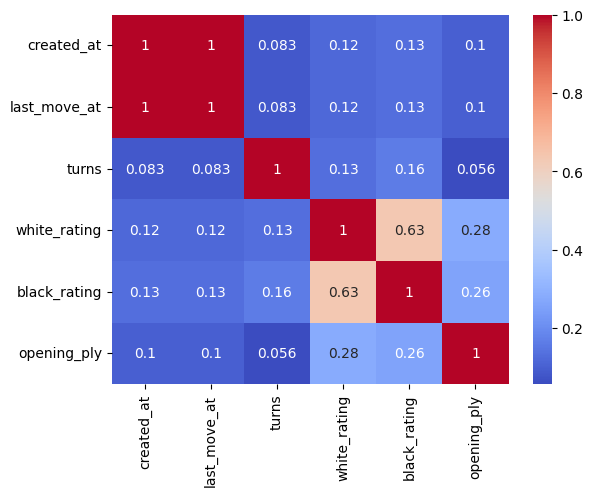

In [6]:
corr_matrix = df.select_dtypes(include=np.number).corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

In [7]:
df.duplicated().sum()

429

In [8]:
df.select_dtypes(include=np.number).describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


In [9]:
df.select_dtypes(include='object').describe()

,id,victory_status,winner,increment_code,white_id,black_id,moves,opening_eco,opening_name
count,20058,20058,20058,20058,20058,20058,20058,20058,20058
unique,19113,4,3,400,9438,9331,18920,365,1477
top,XRuQPSzH,resign,white,10+0,taranga,taranga,e4 e5,A00,Van't Kruijs Opening
freq,5,11147,10001,7721,72,82,27,1007,368


In [10]:
df.isnull().sum()

id                0
rated             0
created_at        0
last_move_at      0
turns             0
victory_status    0
winner            0
increment_code    0
white_id          0
white_rating      0
black_id          0
black_rating      0
moves             0
opening_eco       0
opening_name      0
opening_ply       0
dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


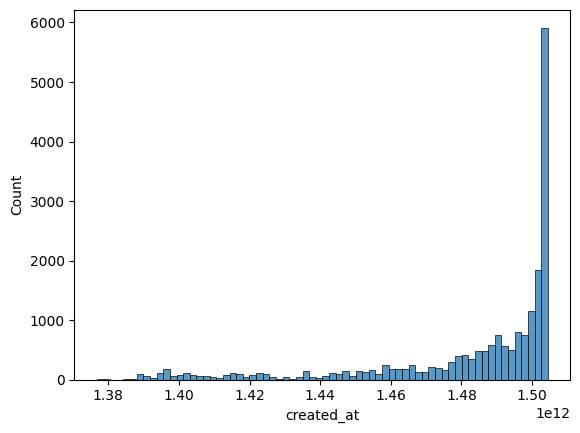

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


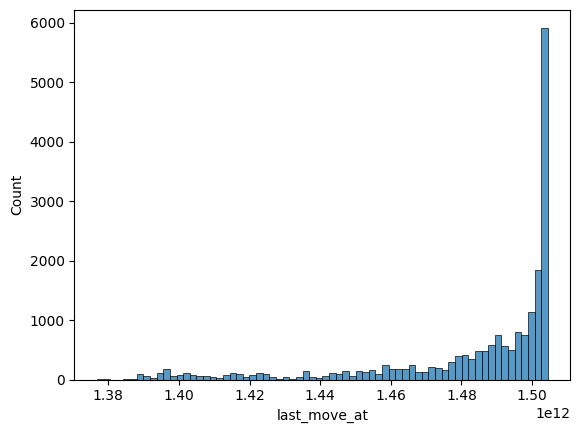

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


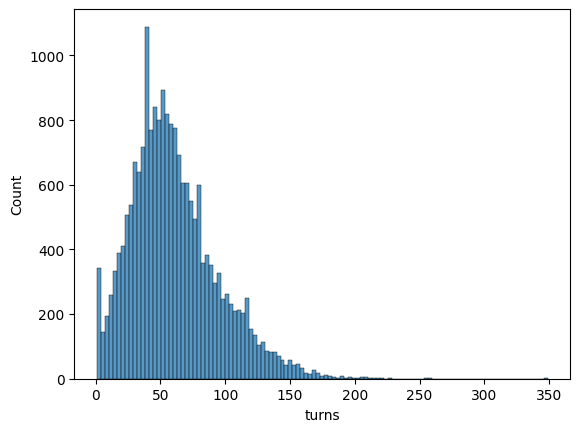

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


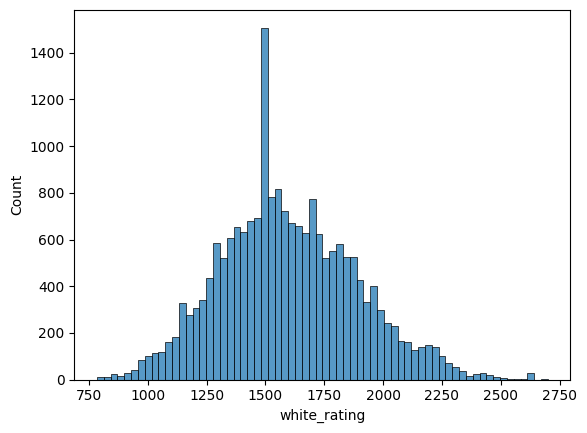

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


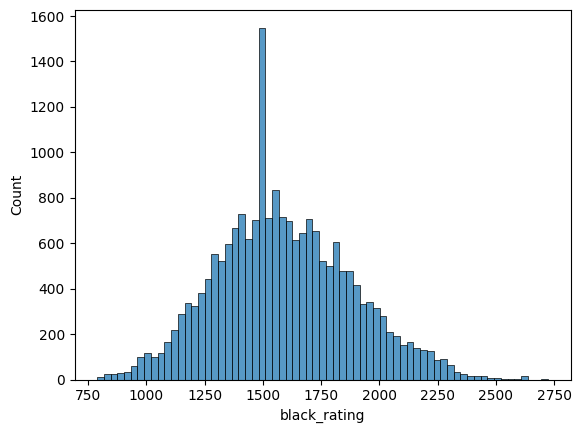

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


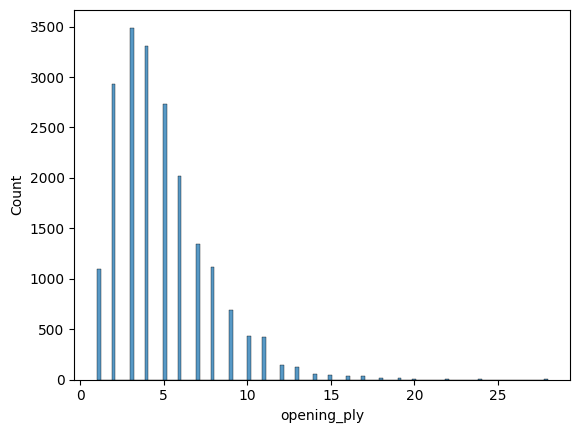

In [11]:
chess_numerical = df.select_dtypes(include=np.number)
chess_categorical = df.select_dtypes(include='object')

for i in chess_numerical:
  sns.histplot(chess_numerical, x=i)
  plt.show()

In [12]:
for i in chess_numerical:
  skewness = df[i].skew()
  print(f"Skewness of {i}: {skewness:.2f}")

Skewness of created_at: -1.78
Skewness of last_move_at: -1.78
Skewness of turns: 0.90
Skewness of white_rating: 0.30
Skewness of black_rating: 0.26
Skewness of opening_ply: 1.33


# feature Enginering

In [13]:
df['duration'] = df['last_move_at'] - df['created_at']
q99 = df['duration'].quantile(0.99)
df['duration_cap'] = np.where(df['duration']> q99, q99, df['duration'])
df['duration_log'] = np.log1p(df['duration_cap'])
df['duration'] = df['duration_log']
df.drop(columns=['duration_cap', 'duration_log', 'created_at', 'last_move_at'], inplace=True)
chess_numerical = df.select_dtypes(include=np.number)

for i in chess_numerical:
  skewness = df[i].skew()
  print(f"Skewness of {i}: {skewness:.2f}")

Skewness of turns: 0.90
Skewness of white_rating: 0.30
Skewness of black_rating: 0.26
Skewness of opening_ply: 1.33
Skewness of duration: -0.24


In [14]:
df['opening_ply'] = np.log1p(df['opening_ply'])
df['opening_ply'].skew()
chess_numerical = df.select_dtypes(include=np.number)

for i in chess_numerical:
  skewness = df[i].skew()
  print(f"Skewness of {i}: {skewness:.2f}")

Skewness of turns: 0.90
Skewness of white_rating: 0.30
Skewness of black_rating: 0.26
Skewness of opening_ply: -0.01
Skewness of duration: -0.24


In [15]:
df[['initial_time', 'increment_time']] = df['increment_code'].str.split('+', expand=True).astype(int)
# df = df.drop('increment_code', axis=1)


In [16]:
df['rating_gap'] = df['white_rating'] - df['black_rating']
# df.drop(columns=['white_rating', 'black_rating'], inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   turns           20058 non-null  int64  
 3   victory_status  20058 non-null  object 
 4   winner          20058 non-null  object 
 5   increment_code  20058 non-null  object 
 6   white_id        20058 non-null  object 
 7   white_rating    20058 non-null  int64  
 8   black_id        20058 non-null  object 
 9   black_rating    20058 non-null  int64  
 10  moves           20058 non-null  object 
 11  opening_eco     20058 non-null  object 
 12  opening_name    20058 non-null  object 
 13  opening_ply     20058 non-null  float64
 14  duration        20058 non-null  float64
 15  initial_time    20058 non-null  int64  
 16  increment_time  20058 non-null  int64  
 17  rating_gap      20058 non-null 

In [18]:
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  int64  
 2   turns           20058 non-null  int64  
 3   victory_status  20058 non-null  object 
 4   winner          20058 non-null  object 
 5   increment_code  20058 non-null  object 
 6   white_id        20058 non-null  object 
 7   white_rating    20058 non-null  int64  
 8   black_id        20058 non-null  object 
 9   black_rating    20058 non-null  int64  
 10  moves           20058 non-null  object 
 11  opening_eco     20058 non-null  object 
 12  opening_name    20058 non-null  object 
 13  opening_ply     20058 non-null  float64
 14  duration        20058 non-null  float64
 15  initial_time    20058 non-null  int64  
 16  increment_time  20058 non-null  int64  
 17  rating_gap      20058 non-null 

In [19]:
chess_categorical = df.select_dtypes(include='object')
for i in chess_categorical:
  print(f""" Unique values of {i}:
  {df[i].unique()}""")

 Unique values of id:
  ['TZJHLljE' 'l1NXvwaE' 'mIICvQHh' ... 'yrAas0Kj' 'b0v4tRyF' 'N8G2JHGG']
 Unique values of victory_status:
  ['outoftime' 'resign' 'mate' 'draw']
 Unique values of winner:
  ['white' 'black' 'draw']
 Unique values of increment_code:
  ['15+2' '5+10' '20+0' '30+3' '10+0' '15+30' '15+0' '20+60' '5+40' '8+0'
 '15+15' '15+16' '11+0' '30+60' '15+5' '10+10' '15+3' '18+0' '30+30'
 '20+25' '5+5' '30+0' '40+40' '16+0' '6+10' '8+10' '8+12' '7+12' '15+10'
 '20+5' '20+10' '45+0' '5+8' '30+2' '25+0' '10+2' '7+2' '25+25' '7+8'
 '6+6' '10+4' '12+0' '15+1' '2+10' '9+0' '10+9' '6+7' '30+10' '30+15'
 '10+3' '45+30' '9+2' '7+3' '6+5' '25+5' '5+7' '8+2' '20+8' '30+5' '25+15'
 '15+7' '8+8' '5+9' '16+7' '10+7' '7+5' '40+20' '10+5' '11+5' '10+15'
 '180+0' '17+5' '8+5' '3+8' '60+120' '90+120' '15+8' '9+1' '9+3' '2+15'
 '10+1' '5+12' '60+10' '5+60' '8+15' '30+25' '12+1' '14+0' '60+20' '10+8'
 '20+3' '14+12' '7+7' '60+0' '45+45' '4+15' '5+6' '180+180' '8+3' '4+6'
 '10+25' '3+10' '7+4' '6+

In [20]:
encoder = LabelEncoder()

for col in df.select_dtypes(include='object').columns:
    df[col] = encoder.fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  int64  
 1   rated           20058 non-null  int64  
 2   turns           20058 non-null  int64  
 3   victory_status  20058 non-null  int64  
 4   winner          20058 non-null  int64  
 5   increment_code  20058 non-null  int64  
 6   white_id        20058 non-null  int64  
 7   white_rating    20058 non-null  int64  
 8   black_id        20058 non-null  int64  
 9   black_rating    20058 non-null  int64  
 10  moves           20058 non-null  int64  
 11  opening_eco     20058 non-null  int64  
 12  opening_name    20058 non-null  int64  
 13  opening_ply     20058 non-null  float64
 14  duration        20058 non-null  float64
 15  initial_time    20058 non-null  int64  
 16  increment_time  20058 non-null  int64  
 17  rating_gap      20058 non-null 

In [21]:
for i in df:
  skewness = df[i].skew()
  print(f"Skewness of {i}: {skewness:.2f}")

Skewness of id: 0.00
Skewness of rated: -1.54
Skewness of turns: 0.90
Skewness of victory_status: -0.56
Skewness of winner: -0.09
Skewness of increment_code: 0.81
Skewness of white_id: 0.03
Skewness of white_rating: 0.30
Skewness of black_id: 0.02
Skewness of black_rating: 0.26
Skewness of moves: -0.00
Skewness of opening_eco: 0.01
Skewness of opening_name: -0.09
Skewness of opening_ply: -0.01
Skewness of duration: -0.24
Skewness of initial_time: 7.77
Skewness of increment_time: 8.88
Skewness of rating_gap: 0.08


In [22]:
# Contoh hasil skewness (ganti ini dengan fungsi skewness dari DataFrame asli)
skewness_values = {
    'id': 0.00,
    'rated': -1.54,
    'created_at': -1.78,
    'last_move_at': -1.78,
    'turns': 0.90,
    'victory_status': -0.56,
    'winner': -0.09,
    'increment_code': 0.81,
    'white_id': 0.03,
    'white_rating': 0.30,
    'black_id': 0.02,
    'black_rating': 0.26,
    'moves': -0.00,
    'opening_eco': 0.01,
    'opening_name': -0.09,
    'opening_ply': -0.01,
    'duration': -0.24,
    'initial_time': 7.77,
    'increment_time': 8.88,
    'rating_gap': 0.08
}

# Perulangan untuk menangani skewness
for col, skewness in skewness_values.items():
    if col in df.columns:  # Pastikan kolom ada di DataFrame
        if skewness > 0.5:  # Skewness positif tinggi
            print(f"Applying log transform to {col} (skewness: {skewness:.2f})")
            df[col] = np.log1p(df[col])  # log1p untuk menghindari log(0)
        elif skewness < -0.5:  # Skewness negatif tinggi
            print(f"Applying exponential transform to {col} (skewness: {skewness:.2f})")
            df[col] = np.exp(df[col])  # Exponential transform
        else:
            print(f"No transform needed for {col} (skewness: {skewness:.2f})")

No transform needed for id (skewness: 0.00)
Applying exponential transform to rated (skewness: -1.54)
Applying log transform to turns (skewness: 0.90)
Applying exponential transform to victory_status (skewness: -0.56)
No transform needed for winner (skewness: -0.09)
Applying log transform to increment_code (skewness: 0.81)
No transform needed for white_id (skewness: 0.03)
No transform needed for white_rating (skewness: 0.30)
No transform needed for black_id (skewness: 0.02)
No transform needed for black_rating (skewness: 0.26)
No transform needed for moves (skewness: -0.00)
No transform needed for opening_eco (skewness: 0.01)
No transform needed for opening_name (skewness: -0.09)
No transform needed for opening_ply (skewness: -0.01)
No transform needed for duration (skewness: -0.24)
Applying log transform to initial_time (skewness: 7.77)
Applying log transform to increment_time (skewness: 8.88)
No transform needed for rating_gap (skewness: 0.08)


In [23]:
for i in df:
  skewness = df[i].skew()
  print(f"Skewness of {i}: {skewness:.2f}")

Skewness of id: 0.00
Skewness of rated: -1.54
Skewness of turns: -1.37
Skewness of victory_status: -0.29
Skewness of winner: -0.09
Skewness of increment_code: 0.14
Skewness of white_id: 0.03
Skewness of white_rating: 0.30
Skewness of black_id: 0.02
Skewness of black_rating: 0.26
Skewness of moves: -0.00
Skewness of opening_eco: 0.01
Skewness of opening_name: -0.09
Skewness of opening_ply: -0.01
Skewness of duration: -0.24
Skewness of initial_time: 1.28
Skewness of increment_time: 0.76
Skewness of rating_gap: 0.08


In [24]:
X = df.drop('turns', axis=1)
y = df['turns']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Pindahkan data ke GPU menggunakan CuPy
# X_train_gpu = cp.array(X_train_scaled)
# y_train_gpu = cp.array(y_train)
# X_test_gpu = cp.array(X_test_scaled)

# # Model dengan GPU
# model = XGBRegressor(tree_method="hist", device="cuda")

# model = RandomForestRegressor(n_estimators=100,max_depth=None,random_state=42,n_jobs=-1)

# model.fit(X_train_scaled, y_train)

# # Prediksi
# y_pred = model.predict(X_test_scaled)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='r2',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


In [ ]:
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Final evaluation on test data
final_preds = best_model.predict(X_test_scaled)
final_rmse = mean_squared_error(y_test, final_preds, squared=False)
print(f"Final RMSE: {final_rmse}")

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

In [ ]:
def predict_perform(X_train, X_test, y_train, y_test):
    # Prediksi
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    

    # Konversi CuPy ke NumPy jika diperlukan (untuk semua variabel)
    if isinstance(y_train, cp.ndarray):
        y_train = y_train.get()
    if isinstance(y_train_pred, cp.ndarray):
        y_train_pred = y_train_pred.get()
    if isinstance(y_test, cp.ndarray):
        y_test = y_test.get()
    if isinstance(y_test_pred, cp.ndarray):
        y_test_pred = y_test_pred.get()

    # Evaluasi
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_test_pred)

    print(f"🔹 R²: {r2:.4f}")
    print(f"🔹 R² Train : {r2_train:.3f}")
    print(f"🔹 R² Test  : {r2_test:.3f}")
    print(f"🔹 MAPE     : {MAPE:.3f}%")

predict_perform(X_train_scaled, X_test_scaled, y_train, y_test)